# Data insights step:
## 1. Words frequencies
## 2. Compute digrams
## 3. Network analysis on bi-grams (degree centrality)
## 4. Words proceeding Rick and Morty

In [1]:
import pandas as pd  # For data handling
import networkx as nx

from gensim.models.phrases import Phrases, Phraser

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from pprint import pprint
    
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline  

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

### Read processed dialogs

In [159]:
df = pd.read_csv("data/processed_simpsons_dataset.csv")

### Compute digrams which have at least a frequency equal with 2

In [161]:
sent = [row.split() for row in df['spoken_words']]

bigram_phraser = Phrases(sent, min_count=5, progress_per=10000)

sentences = bigram_phraser[sent]

INFO - 18:32:22: collecting all words and their counts
INFO - 18:32:22: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 18:32:22: PROGRESS: at sentence #10000, processed 63414 words and 52395 word types
INFO - 18:32:22: PROGRESS: at sentence #20000, processed 130387 words and 98568 word types
INFO - 18:32:23: PROGRESS: at sentence #30000, processed 192369 words and 137101 word types
INFO - 18:32:23: PROGRESS: at sentence #40000, processed 249283 words and 170989 word types
INFO - 18:32:23: PROGRESS: at sentence #50000, processed 310323 words and 206466 word types
INFO - 18:32:23: PROGRESS: at sentence #60000, processed 372264 words and 241169 word types
INFO - 18:32:23: PROGRESS: at sentence #70000, processed 434951 words and 275773 word types
INFO - 18:32:23: PROGRESS: at sentence #80000, processed 496169 words and 308714 word types
INFO - 18:32:23: collected 329886 word types from a corpus of 540709 words (unigram + bigrams) and 86834 sentences
INFO - 18:32:23: us

### Compute the frequency of single words and bigrams

In [27]:
bigrams = dict()
words = dict()

for s in sent:
    for word in s:
        words.setdefault(word, 0)
        words[word] += 1

for sentence in sentences:
    for word in sentence:
        if "_" in word:
            bigrams.setdefault(word, 0)
            bigrams[word] += 1

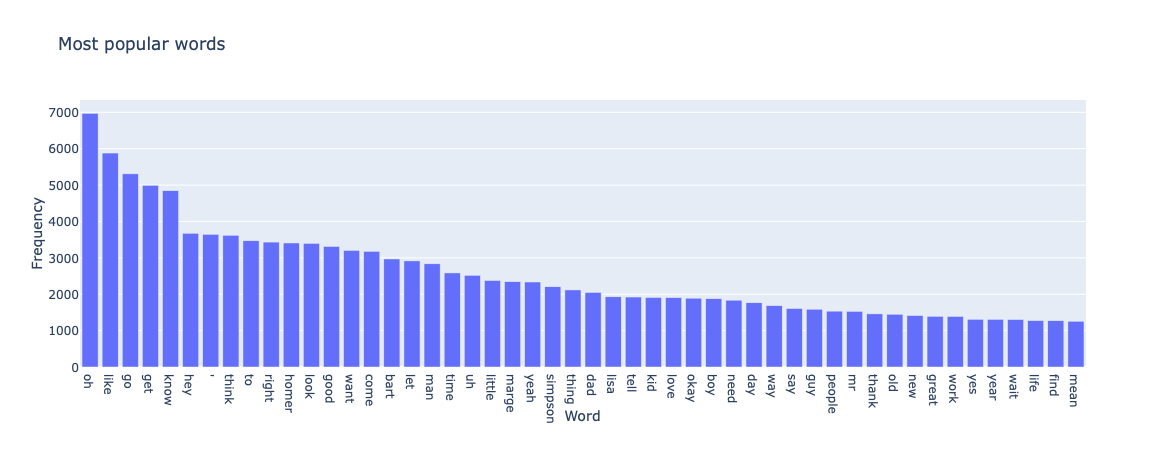

In [162]:
import operator

sorted_words = sorted(words.items(), key=operator.itemgetter(1), reverse=True)[:50]
data = [go.Bar(y=[x[1] for x in sorted_words], x=[x[0] for x in sorted_words])]

layout=go.Layout(title="Most popular words", xaxis={'title':'Word'}, yaxis={'title':'Frequency'})
figure=go.Figure(data=data, layout=layout)
    
iplot(figure, filename='most-popular-words')

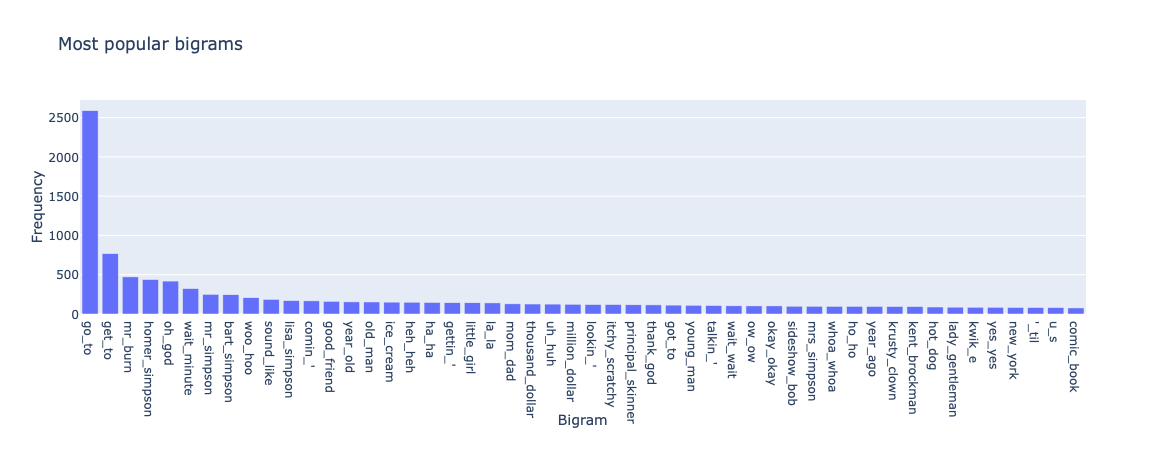

In [163]:
sorted_bigrams = sorted(bigrams.items(), key=operator.itemgetter(1), reverse=True)[:50]
data = [go.Bar(y=[x[1] for x in sorted_bigrams], x=[x[0] for x in sorted_bigrams])]

layout=go.Layout(title="Most popular bigrams", xaxis={'title':'Bigram'}, yaxis={'title':'Frequency'})
figure=go.Figure(data=data, layout=layout)
    
iplot(figure, filename='most-popular-bigrams')

In [95]:
from textblob import TextBlob

sentiments = []
for i, row in df.iterrows():
    doc = TextBlob(row['spoken_words'])
    sentiments.append(doc.sentiment.polarity)                  

In [96]:
normalised_sentiments = [float(i)/max(sentiments) for i in sentiments]

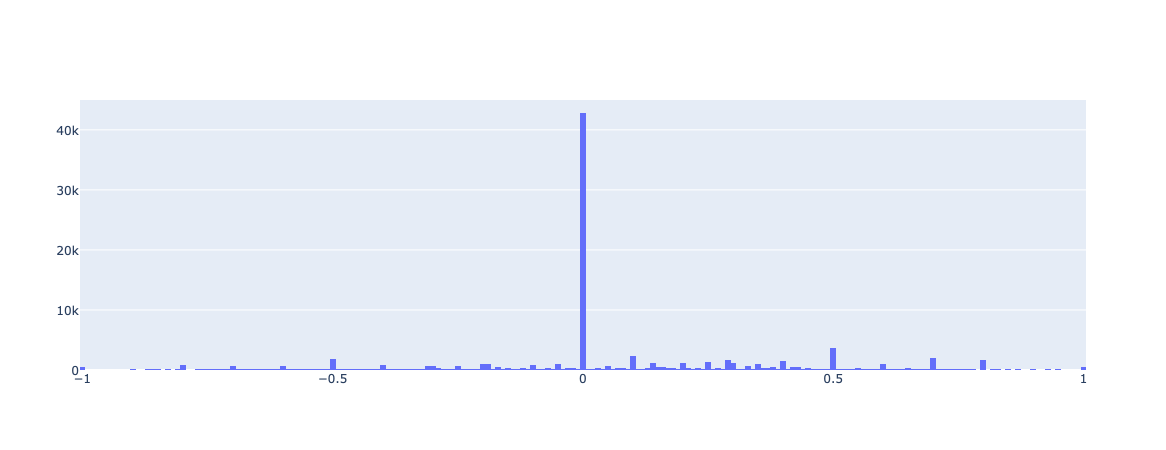

In [97]:
fig = go.Figure(data=[go.Histogram(x=[v for v in normalised_sentiments])])

iplot(fig, filename='Sentiments')

### Generate a network, where nodes are words and an edge exists between each that appear after one another more than twice

In [101]:
marge_nodes = {}
homer_nodes = {}


for s in sent:
    for i, word in enumerate(s):
        if word == 'marge':
            if i + 1 <= len(s)-1: 
                marge_nodes.setdefault(s[i+1], {})
                if i + 2 <= len(s) - 1: 
                    marge_nodes[s[i+1]].setdefault(s[i+2], {})
                    
        if word == 'homer':
            if i + 1 <= len(s)-1: 
                homer_nodes.setdefault(s[i+1], {})
                if i + 2 <= len(s) - 1: 
                    homer_nodes[s[i+1]].setdefault(s[i+2], {})

In [143]:
G = nx.Graph()
G.add_node("homer", freq=words["homer"])
G.add_node("marge", freq=words["marge"])

for k, v in homer_nodes.items():
    if words[k] < 1000:
        continue
        
    G.add_node(k, freq=words[k])
    
    for a, _ in v.items():
        if words[a] < 1000:
            continue
            
        G.add_node(a, freq=words[a])
        G.add_edge(a, k)
        
    G.add_edge(k, "homer")
    
for k, v in homer_nodes.items():
    if words[k] < 1000:
        continue
        
    G.add_node(k, freq=words[k])
    
    for a, _ in v.items():
        if words[a] < 1000:
            continue
            
        G.add_node(a, freq=words[a])
        G.add_edge(a, k)
        
    G.add_edge(k, "marge")

In [144]:
print(len(list(G.neighbors('homer'))))
print(len(list(G.neighbors('marge'))))

62
62


In [146]:
print(len(G.nodes()), len(G.edges()))

66 312


In [149]:
sorted(nx.degree_centrality(G).items(), key=operator.itemgetter(1), reverse=True)[:10]

[('homer', 0.9692307692307693),
 ('marge', 0.9692307692307693),
 ('simpson', 0.49230769230769234),
 ('think', 0.35384615384615387),
 ('get', 0.2923076923076923),
 ('look', 0.27692307692307694),
 ('want', 0.26153846153846155),
 ('know', 0.2153846153846154),
 ('tell', 0.18461538461538463),
 ('go', 0.18461538461538463)]

In [172]:
paths = nx.all_simple_paths(G, "homer", "marge")

In [173]:
for path in paths:
    print(path)
    break
#     if len(path) == 9:
#         print(path)

['homer', 'great', 'simpson', 'big', 'like', 'think', 'know', 'bart', 'look', 'marge']
